In [1]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta
from model_settings import ms
from historical_av_plot_vol_surface import plot_vol_surface
fontsize=6
plt.rcParams.update(
    {
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.titlesize': fontsize,
        'axes.linewidth': 1/3,
    }
)

symbol='NVDA'
url = str(
	'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+
	symbol+'&outputsize=full&apikey='+
	ms.av_key)
print(symbol)
r = requests.get(url)
spots = pd.Series(pd.DataFrame(r.json()['Time Series (Daily)']).transpose()['4. close'].squeeze())
spots = pd.to_numeric(spots,errors='coerce')
print(spots)


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

NVDA
2024-10-11    134.80
2024-10-10    134.81
2024-10-09    132.65
2024-10-08    132.89
2024-10-07    127.72
               ...  
1999-11-05     28.25
1999-11-04     29.19
1999-11-03     27.44
1999-11-02     25.00
1999-11-01     23.50
Name: 4. close, Length: 6277, dtype: float64


# example data collection

let us collect a few recent trading days and inspect the data

In [2]:
dates = spots.index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-11
1    2024-10-10
2    2024-10-09
3    2024-10-08
4    2024-10-07
dtype: object


In [3]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date,spot,symbol)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


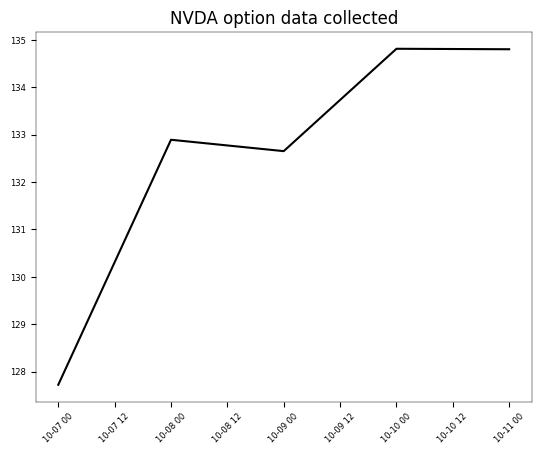

<Figure size 640x480 with 0 Axes>

In [4]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [5]:
date = dates[3]
raw_data = chain[date]
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Tuesday, October 8th, 2024


## modelling the volatility surface

In [6]:
df = raw_data.copy()
columns_to_convert = ['strike', 'last', 'mark',
       'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho']
df[columns_to_convert] = df[
    columns_to_convert].apply(pd.to_numeric, errors='coerce')

df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]

df = df[df['volume']>0].copy()
df['spot_price'] = spot

df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(
    np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass
        
        
hottest_contracts = pd.DataFrame(
    volume_heatmap.unstack().sort_values(
        ascending=False)).head(50).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]
        
hottest_contracts = hottest_contracts.rename(
    columns={'t':'days_to_maturity','k':'strike_price'}).copy()


NVDA spot price: 127.72

           31       38       45       73       101      136      164      255
100.0  0.61570  0.58979  0.62820  0.57622  0.55046  0.54924  0.55275  0.53842
110.0  0.55412  0.54009  0.58857  0.55366  0.53247  0.53506  0.54070  0.53080
115.0  0.53323  0.52241  0.57119  0.54375  0.52470  0.52866  0.53659  0.52820
118.0  0.52409  0.51433  0.53796  0.54055  0.52104  0.52592  0.53461  0.52698
120.0  0.51891  0.50915  0.56067  0.53811  0.51936  0.52531  0.53293  0.52607
125.0  0.50153  0.49695  0.56098  0.53110  0.51403  0.52058  0.52988  0.52455
130.0  0.49863  0.49162  0.54238  0.53003  0.51433  0.52058  0.53019  0.52500
132.0  0.49391  0.48857  0.57637  0.53461  0.51738  0.52500  0.53247  0.52455
135.0  0.48644  0.48171  0.54299  0.52485  0.51296  0.51784  0.53003  0.52211
136.0  0.48689  0.48171  0.49619  0.52836  0.51342  0.52119  0.52851  0.52165
138.0  0.48125  0.47622  0.49055  0.52226  0.51083  0.51906  0.52759  0.52134
140.0  0.47897  0.47211  0.54177  0.51

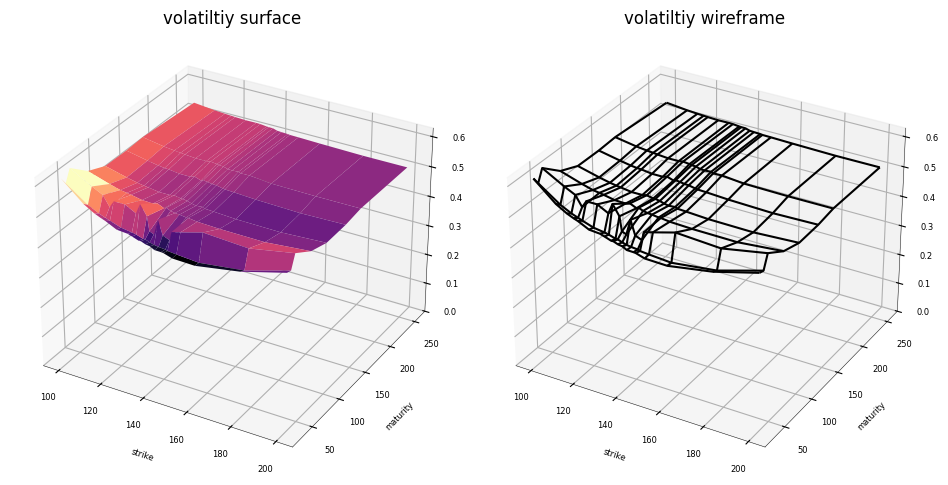

<Figure size 640x480 with 0 Axes>

In [7]:
s = float(df['spot_price'].unique()[0])
print(f"\n{symbol} spot price: {s}")
print(f"\n{vol_matrix}\n")
plot_vol_surface(vol_matrix)

## calibrating a Heston (1993) model

In [8]:
vol_matrix = vol_matrix.sort_index().drop_duplicates()
pd.to_numeric(raw_data['last'])
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility']).astype(float)
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities

T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)

## testing calibration accuracy

In [9]:
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"\n{printdate}\n{heston_parameters}\naverage absolute error: {round(avg,3)}")
print(f"calibration testing dataset:\n{calibration_test_data.describe()}")


Monday, 2024-10-07
theta     0.308538
kappa    36.777940
eta       6.445575
rho      -0.335719
v0        0.190021
dtype: float64
average absolute error: 0.406
calibration testing dataset:
       strike_price  market_price   volatility  days_to_maturity  \
count   3748.000000   3748.000000  3748.000000       3748.000000   
mean     112.195838     24.116422     0.791438        140.538420   
min        0.500000      0.000000     0.062460         31.000000   
25%       58.000000      0.050000     0.523330         73.000000   
50%      105.000000      6.760000     0.586355        101.000000   
75%      163.000000     40.775000     0.789857        220.000000   
max      280.000000    139.550000     8.599200        346.000000   
std       67.456193     32.268577     0.601462         93.279558   

         spot_price  risk_free_rate  dividend_rate         theta       kappa  \
count  3.748000e+03    3.748000e+03         3748.0  3.748000e+03  3748.00000   
mean   1.277200e+02    4.000000e-02   

# train data generation

In [10]:
strike_spread = 0.2
strike_step = 5
K = np.arange(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    strike_step
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.arange(
    s*0.5,
    s*0.99,
    barrier_step
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


NVDA spot price:
     127.72

strikes:
     [102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152]

barriers:
     [63, 73, 83, 93, 103, 113, 123]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [11]:
print('generating contracts...')
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        [calculation_datetime],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'calculation_date',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = ms.vector_heston_price(features)
features['barrier_price'] = ms.vector_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')

generating contracts...
contracts generated
pricing 2156 contracts...


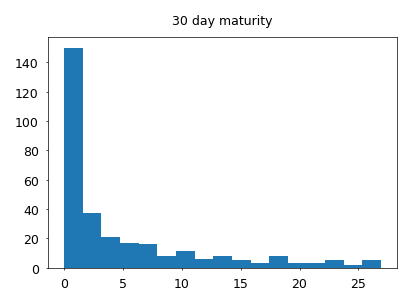

<Figure size 640x480 with 0 Axes>

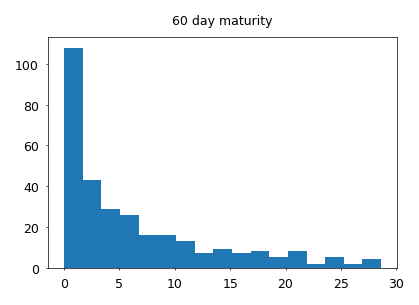

<Figure size 640x480 with 0 Axes>

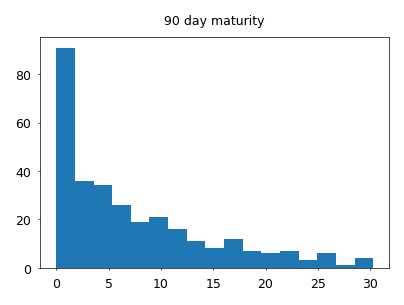

<Figure size 640x480 with 0 Axes>

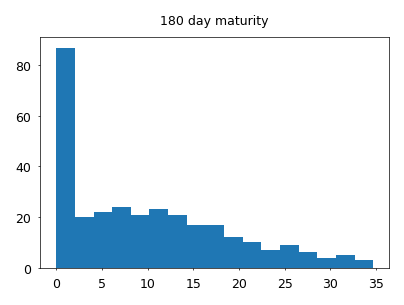

<Figure size 640x480 with 0 Axes>

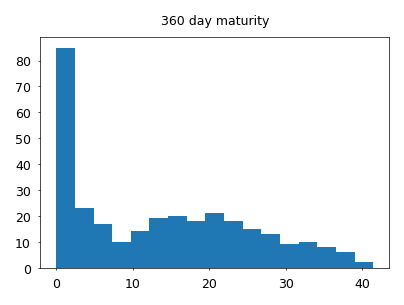

<Figure size 640x480 with 0 Axes>

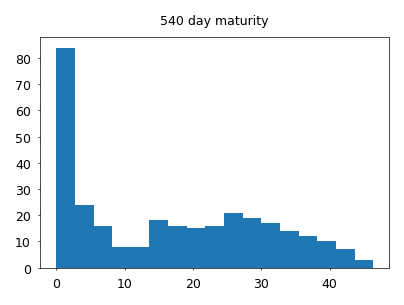

<Figure size 640x480 with 0 Axes>

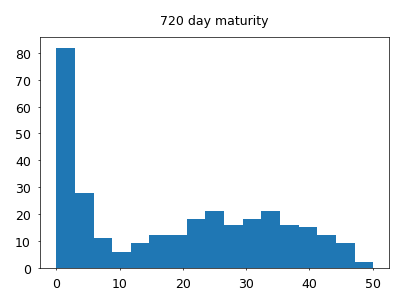

<Figure size 640x480 with 0 Axes>

In [12]:
for t in T:
    plt.figure(figsize=(3, 2), dpi=150)
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.tick_params(axis='both', which='major', length=1, width=1/3)  # Thinner tick marks
    plt.title(f'{t} day maturity', fontsize=fontsize)
    plt.show()
    plt.clf()

# model training

In [13]:
import convsklearn
help(convsklearn)

a proprietary package of convenience wrappers for sklearn
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()

Help on package convsklearn:

NAME
    convsklearn

PACKAGE CONTENTS
    convsklearn

DATA
    barrier_trainer = <convsklearn.convsklearn.convsklearn object>
    categorical_features = ['barrier_type_name', 'w']
    feature_set = ['spot_price', 'strike_price', 'days_to_maturity', 'risk...
    numerical_features = ['spot_price', 'strike_price', 'days_to_maturity'...
    targe

In [14]:
help(convsklearn.convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline, n_layers=None, random_state=None, max_iter=1000, solver='sgd', alpha=0.0001, learning_rate='adaptive', activation_function='relu', rf_n_estimators=50, rf_min_samples_leaf=2000)
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline, n_layers=None, random_state=None, max_iter=1000, solver='sgd', alpha=0.0001, learning_rate='adaptive', activation_function='relu', rf_n_estimators=50, rf_min_samples_leaf=2000)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  get_train_test_arrays(self, train_data, test_data, feature_set=None, target_name=None)
 |
 |  plot_model_performance(self, df, X_name, Y_name, xlabel, ylabel, runtime, title)
 |
 |  preprocess(self)
 |
 |  ru

In [15]:
from convsklearn import target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline

In [16]:
barrier_trainer = convsklearn.convsklearn(
    target_name=target_name, 
    numerical_features=numerical_features, 
    categorical_features=categorical_features, 
    transformers=transformers, 
    target_transformer_pipeline=target_transformer_pipeline, 
    max_iter=1000
)

random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



In [17]:
features['observed_price'] = ms.noisyfier(features.loc[:,'barrier_price']) 
    # apply slight peturbation in the form of a random normal with standard deviation 0.15
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target', 
        'outofsample_prediction':'dnn', 
        'outofsample_error' : 'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")
print(f"\n{outsample_preview}")
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 

train data count: 1848
test data count: 308

training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RSME: 2.0069614851483157
     MAE: 1.4679749284642556

out of sample:
     RSME: 4.611978091939143
     MAE: 3.535368042352803

        spot      k      b  price  vanilla      t  target    dnn  error
count 308.00 308.00 308.00 308.00   308.00 308.00  308.00 308.00 308.00
mean  127.72 127.00  93.00  18.59    37.16 720.00   18.59  17.30  -1.28
std     0.00  15.84  20.03  15.26     9.07   0.00   15.26  12.63   4.44
min   127.72 102.00  63.00   0.00    19.06 720.00    0.00  -2.74 -14.83
25%   127.72 112.00  73.00   2.46    31.52 720.00    2.54   4.87  -4.05
50%   127.72 127.00  93.00  19.06    37.73 720.00   19.01  19.24  -0.79
75%   127.72 142.00 113.00  31.63    43.80 720.00   31.67  28.40   1.52
max   127.72 152.00 123.00  50.09    52.52 720.00   50.23  42.91   9.46

NVDA down barrier options f